# Results: Early period

This notebook displays BML results for the early period.

In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
library(brms)
library(dplyr)
library(data.table)

library(tidyverse)
library(ggridges)
options(warn = -1)

## Model

The minimum for $s$th subject and $r$th ROI at $t$th timepoint across safe and threat is:

$$m_{s,r,t} = \underset{\text{safe, threat}}{\mathrm{Min}}\{y_{s,r,t,\text{safe}}, y_{s,r,t,\text{threat}}\}$$

And for given time window $p=\text{early, late}$, the difference between responses to safe and threat is:

$$
\begin{aligned}
\Delta_{s,r} & = \sum_{t}^{t \in p}(y_{s,r,t,\text{threat}} - m_{s,r,t}) - \sum_{t}^{t \in p}(y_{s,r,t,\text{safe}} - m_{s,r,t}) \\
             & = \sum_{t}^{t \in p}(y_{s,r,t,\text{threat}} - y_{s,r,t,\text{safe}})
\end{aligned}
$$

The model for given time window $p$ then can be expressed in terms of a linear mixed effect model notation (lme-like) as: 

$$
\Delta_{s,r} \sim 1 + \text{State} + \text{Trait} + (1|\text{Sub}) + (1 + \text{State} + \text{Trait} | \text{ROI})
$$

Based on the distribution of summarized-estimated activation, the full model in the notation of \citet{mcelreath2018statistical} is:

$$
\Delta_{s,r} \sim \text{Student t}(\nu, \mu_{s,r},\sigma^{2})
$$

and,

$$
\begin{aligned}
\mu_{s,r} = \ & \alpha + \alpha_{\text{subj}[s]} + \alpha_{\text{roi}[r]} \ + \\
            & (\beta_{\text{state}} + \beta_{\text{state}, \text{roi}[r]}) \times \text{State}_{s} \ +  \\
            & (\beta_{\text{trait}} + \beta_{\text{trait}, \text{roi}[r]}) \times \text{Trait}_{s}
\end{aligned}
$$

where, 

$$
\alpha_{\text{subj}[s]} \sim \text{Student t}(\nu_{\text{subj}}, \ 0, \ \sigma_{\alpha_{\text{subj}}}^{2})
$$

$$
\begin{bmatrix}
\alpha_{\text{roi}[r]} \\
\beta_{\text{state}, \text{roi}[r]} \\
\beta_{\text{trait}, \text{roi}[r]}
\end{bmatrix} \sim \text{Multivariate t}
\begin{pmatrix}
\nu_{\text{roi}}, \ 
\begin{bmatrix}
 0 \\ 0 \\ 0
\end{bmatrix}, \text{ } \mathbf{S}
\end{pmatrix}
$$

and,

$$
\begin{aligned}
    \mathbf{S} & = 
    \begin{pmatrix}
        \sigma_{\alpha_{\text{roi}}}^2 &   \rho_{1,2}\sigma_{\alpha_{\text{roi}}}\sigma_{\beta_{\text{state}, \text{roi}}} &
        \rho_{1,3}\sigma_{\alpha_{\text{roi}}}\sigma_{\beta_{\text{trait}, \text{roi}}} \\
            &
        \sigma_{\beta_{\text{trait}, \text{roi}}}^2 & 
        \rho_{2,3}\sigma_{\beta_{\text{state}, \text{roi}}}\sigma_{\beta_{\text{trait}, \text{roi}}} \\
            &
            & 
        \sigma_{\beta_{\text{trait}, \text{roi}}}^2
    \end{pmatrix} \\
                    & = 
    \begin{pmatrix}
        \sigma_{\alpha_{\text{roi}}} &   &   \\
        &   \sigma_{\beta_{\text{state}, \text{roi}}}  &   \\
        &   &   \sigma_{\beta_{\text{trait}, \text{roi}}}
    \end{pmatrix} \mathbf{R}
    \begin{pmatrix}
        \sigma_{\alpha_{\text{roi}}} &   &   \\
        &   \sigma_{\beta_{\text{state}, \text{roi}}}  &   \\
        &   &   \sigma_{\beta_{\text{trait}, \text{roi}}}
    \end{pmatrix}
\end{aligned}
$$

and,

$$
\mathbf{R} = 
\begin{pmatrix}
    1   &   \rho_{1,2}  &   \rho_{1,3}  \\
        &   1   &   \rho_{2,3}   \\
        &   &   1
\end{pmatrix}
$$


* $\mu_{s,r}$ Mean difference of estimated activation of $s$th subject and $r$th ROI, where $s=1,2,...,N_{\text{subj}}$ and $r=1,2,...,N_{\text{roi}}$
* $\text{State}_{s}$ State anxiety score for $s$th subject
* $\text{Trait}_{s}$ Trait anxiety score for $s$th subject
* $\alpha$ population (fixed) intercept
* $\beta_{j}$ population (fixed) slope, $j=\text{state, trait}$
* $\alpha_{\text{subj}[s]}$  groups (random) intercept for $s$th subject
* $\alpha_{\text{roi}[r]}$ groups (random) intercept for $r$th ROI
* $\beta_{j, \text{roi}[r]}$ groups (random) slope for $r$th ROI, $j=\text{state, trait}$

***Priors.*** The choice of prior distributions are vital \citep{Gabry2019visualization} and weakly informative priors are often suggested and applied to let data lead the model \citep{gelman2009bayes}. The current model employed \emph{Stan} default prior distribution for the intercept $\alpha$ and all standard deviations $\sigma$, but the default priors for slopes $\beta$, degrees of freedom $\nu$ and correlation coefficient matrix $\mathbf{R}$ were too weak. Utilizing the default priors for these terms could lead to more time cost in sampling and potentially divergent issues, therefore we used more informative priors on these parameters.

As a result, the slopes and intercepts for employed weakly-informative priors are defined as:
$$\alpha \sim \text{Student t}(3, \mu_{y}, 2.5)$$
$$\beta_{j} \sim \text{Student t}(3, 0, 2.5)$$
$$\sigma \sim \text{Half Student}(3, 0, 2.5)$$
$$\nu \sim \text{Gamma}(3.325, 0.2)$$
$$\nu_{\text{subj}} \sim \text{Gamma}(3.325, 0.2)$$
$$\nu_{\text{roi}} \sim \text{Gamma}(3.325, 0.2)$$
$$\sigma_{\alpha_{\text{subj}}} \sim \text{Half Student}(3, 0, 2.5)$$
$$\sigma_{\alpha_{\text{roi}}} \sim \text{Half Student}(3, 0, 2.5)$$
$$\sigma_{\beta_{j, \text{roi}}} \sim \text{Half Student}(3, 0, 2.5)$$
$$\mathbf{R} \sim \text{LKJcorr}(2)$$
notice that $\mu_{y}$ is the sample mean of $\Delta_{s,r}$;

The posterior distributions for parameters are given after sampling. However, the effect of trial or STAI scores on the difference of responses for each ROI is composed by two parts: fixed effect of population and random effects of ROIs. Hence, the final posterior distribution of trial (intercept) is given by:

$$
p_{\text{trial}, [i, r]} = p_{\alpha, [i]} + p_{\alpha_{\text{roi}[r]}, [i]}
$$

where,
* $p_{\alpha, [i]}$: posterior sample for fixed intercept $\alpha$ at $i$th iteration
* $p_{\alpha_{\text{roi}[r]}, [i]}$: posterior sample for random intercept $\alpha_{roi[r]}$ of $r$th ROI at $i$th iteration
And scores (slopes) are given by:

$$p_{k, [i, r]} = p_{\beta_{k}, [i]} + p_{\beta_{k, roi[r]}, [i]}$$

where,
* $k=\text{state, trait}$
* $p_{\beta_{k}, [i]}$: posterior sample for fixed $k$ slope $\beta_{k}$ at $i$th iteration
* $p_{\beta_{k, roi[r]}, [i]}$: posterior sample for random slope of $\beta_{k, roi[r]}$ of $r$th ROI at $i$th iteration

Additionally, to illustrate the impact of the trial and STAI scores to the responses, a summary statistic is introduced as $P+$ value: the probability of a coefficient larger than 0

$$P+_{K, [r]} = P(p_{K, [i, r]} > 0) = \dfrac{\sum\limits_{i=1}^{N}g(p_{K, [i,r]})}{N}$$

where,

* $g(p_{K, [i,r]})=
            \begin{cases}
                1,   &   p_{K, [i,r]} > 0 \\
                0,  &   \text{else}
            \end{cases}$
* $K = \text{trial, state, trait}$
* $N$: number of samples (iterations).

In [4]:
# Load the BML output image

phase <- 'late'

load(paste0('results_offset/', phase, '_diff.RData'))
outDir = paste0('results_offset/', phase, '_')
summary_file = paste0(outDir, 'summary.txt')

In [5]:
print('Following are the first few rows of thet dataset used in BML')
head(dataTable)

[1] "Following are the first few rows of thet dataset used in BML"


,Subj,ROI,diff,TRAIT,STATE
,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,MAX101,L_ACC,0.0424938,-1.164152,-1.011495
2,MAX101,L_BLBM_Amygdala,-2.3971760,-1.164152,-1.011495
3,MAX101,L_BST,0.4968420,-1.164152,-1.011495
4,MAX101,L_CeMe_Amygdala,0.1588130,-1.164152,-1.011495
5,MAX101,L_CrusI-krienen,-0.4170045,-1.164152,-1.011495
6,MAX101,L_CrusI-shackman,0.6649851,-1.164152,-1.011495


In [6]:
EOIq <- unlist(lapply(strsplit(mod,'\\+')[[1]],trimws))
if(!('Intercept' %in% EOIq)) EOIq <- c('Intercept', EOIq)
EOIq <- EOIq[!grepl('1', EOIq)]

print('Fixed effect model terms:')
print(EOIq)

[1] "Fixed effect model terms:"
[1] "Intercept" "TRAIT"     "STATE"    


In [7]:
# Print the BML output summary
cat('====================================== BML output Summary ======================================',
    file = summary_file, sep = '\n')
cat(capture.output(summary(fm)), file = summary_file, sep = '\n')
print(summary(fm))

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: diff ~ 1 + TRAIT + STATE + (1 + TRAIT + STATE | gr(ROI, dist = "student")) + (1 | gr(Subj, dist = "student")) 
   Data: dataTable (Number of observations: 9265) 
Samples: 4 chains, each with iter = 20000; warmup = 10000; thin = 1;
         total post-warmup samples = 40000

Group-Level Effects: 
~ROI (Number of levels: 85) 
                     Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
df                      14.77      8.22     4.45    35.89 1.01      874
sd(Intercept)            0.29      0.03     0.23     0.35 1.00     2715
sd(TRAIT)                0.05      0.02     0.01     0.08 1.00     9335
sd(STATE)                0.04      0.01     0.01     0.07 1.00     8887
cor(Intercept,TRAIT)    -0.28      0.22    -0.69     0.18 1.00    36188
cor(Intercept,STATE)    -0.41      0.24    -0.82     0.13 1.00    32312
cor(TRAIT,STATE)         0.40      0.30    -0.26     0.87 1.00    20095
              

In [8]:
# Extract posteriors for fixed (aa) and random effects (bb)
aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)

# Sum the fixed and random effect (only ROI) posterior. Following function does this.
# The function adds the "the poaterior of the global intercept (or slope) with the 
# intercept (or slope) posterior of each roi. bb[['ROI']][,,tm] is a matrix with 
# columns containing posteriors for every ROI
# aa[,tm] is a single column posterior for the global intercept/slope.
# intercept or slope is defined by tm, where tm is the index of the model term.
psROI <- function(aa, bb, tm) {
  ps <- apply(bb[['ROI']][,, tm], 2, '+', aa[, tm])
  return(ps)
}

#################################### Following functions are used for summarizing BML and GLM outputs in a table from ############################
# function to compute P+
cnt <- function(x, ns) return(sum(x > 0) / ns)

# function that creates a BML summary table for ROI posteriors (mean, std, and quartiles),
# nd - number of digits to output
sumROI <- function(samples, ns, nd) {
    hubs <- data.frame(cbind(apply(samples, 2, mean), 
                             apply(samples, 2, sd), 
                             apply(samples, 2, cnt, ns), 
                             t(apply(samples, 2, quantile, probs=c(0.025, 0.05, 0.5, 0.95, 0.975)))))
    names(hubs) <- c('mean', 'SD', 'P+', '2.5%', '5%', '50%', '95%', '97.5%')
    return(round(hubs,nd))
}

In [9]:
# Following print BML result summary for each ROI
for (ii in 1:length(EOIq)){

    cat(sprintf('========= Summary of region effects for %s (RBA results) =========', EOIq[ii]), 
        file = summary_file, sep = '\n', append=TRUE)
    ps0 <- psROI(aa, bb, EOIq[ii])
    gg_brm <- sumROI(ps0, ns, nfigs)
    write.table(gg_brm,file = paste0(outDir, EOIq[ii], '.txt'), sep = ',')

    cat(capture.output(gg_brm), file = summary_file, sep = '\n', append=TRUE)

    cat(sprintf('==================================================================================================================='), 
        file = summary_file, sep='\n', append=TRUE)
}

In [10]:
# Function to generate posterior distribution for each ROI of intercept, STATE and TRAIT
# together with P+ values

plotPDP <- function(posteriors){
    # prepare the dataframe
    posteriors <- posteriors %>% as_tibble()
    
    name <- read.table("data/ROI_name_dict.txt", header = TRUE, sep = ",")
    name[] <- lapply(name, as.character)
    name[] <- lapply(name, str_trim, side = "both")
    colnames(posteriors) <- stringr::str_replace_all(posteriors %>% colnames(), setNames(pull(name["new"]), pull(name["old"])))
    
    p_plus <- function(x){
        return(sum(x > 0, na.rm = TRUE)/length(x))
    }
    
    P_df <- apply(posteriors, 2, p_plus) %>% as.data.frame()
    P_df <- tibble(ROI = row.names(P_df), 
                   p_plus = P_df[, 1],
                   mean = apply(posteriors, 2, mean))
    P_df <- P_df %>% arrange(p_plus, mean) %>% mutate(rank = c(1: dim(P_df)[1]))
    
    ps_long <- gather(posteriors, key = "ROI", value = "posterior")
    
    ps_long <- full_join(ps_long, P_df, by = "ROI") %>% 
                    mutate(p.plot = p_plus) %>% 
                    mutate(p.plot = replace(p.plot, p.plot > 0.15 & p.plot < 0.85, NA))
    
    ## starting plotting
    plot <- ps_long %>%
        ggplot(aes(x = posterior, y = as.numeric(rank), group = ROI, fill = p.plot)) +
        coord_cartesian(xlim = c(min(ps_long$posterior) - min(ps_long$posterior)/9, 
                                 max(ps_long$posterior) - max(ps_long$posterior)/6), 
                        clip = "off") +
        geom_density_ridges(scale = 2.25, 
                            rel_min_height = .001, 
                            alpha = 0.8, 
                            color = '#cccccc',
                            quantile_lines = TRUE,
                            quantiles = 2, 
                            size = 0.5) +
        geom_vline(xintercept = 0, alpha = .85, color = "black", size = .8, linetype = "dashed") +
        scale_x_continuous(breaks = c(-1.0, 0, 0.5), 
                           labels = c("Safe > Threat", "0", "Safe < Treat")) +
        scale_y_continuous(breaks = 1:length(P_df$ROI),
                           expand = c(0,0.1),
                           labels = P_df$ROI,
                           sec.axis = sec_axis(~.,
                                               breaks = 1:length(P_df$ROI),
                                               labels = format(round(P_df$p_plus, 3), nsmall = 2))) +
        scale_fill_gradientn(limits = c(0,1),
                             colors = c("#33F7FF", "#67D7FD", "#3A73FC", "#333AFE", "#1D38FD", "#01007A",
                                        "#505154",
                                        "#83FD4C", "#FDFD67", "#FFC300", "#FF5733", "#C70039", "#A50A0A"),
                             values = c(0, 0.025, 0.0250000001, 0.05, 0.050000001, 0.075, 
                                        0.0750000001, 0.1, 0.10000001, 0.125, 0.1250000001, 0.15,
                                        0.150000001, 0.85, 
                                        0.850000001, 0.875, 0.8750000001, 0.9, 0.90000001, 0.925, 
                                        0.9250000001, 0.95, 0.950000001, 0.975, 0.9750000001, 1.0),
                             breaks = c(0, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 1)) +
        guides(fill = guide_colorbar(barwidth = 1.25,
                                     barheight = 8,
                                     nbin = 50,
                                     frame.colour = "black",
                                     frame.linewidth = 0.75,
                                     ticks.colour = "black")) +
        theme_ridges(center_axis_labels = TRUE, grid = FALSE) +
        theme(
            plot.background = element_blank(),
            panel.background = element_blank(),
            panel.grid.major.y = element_line(color = "lightgray", size = .75),
            plot.title = element_text(size = 17, margin = unit(c(0,0.1,.25,02),"cm"), face = "plain", hjust = -0.5),
            plot.margin = unit(c(1, 2.5, 1, 1), "cm"),
            legend.title = element_text(size = 15, hjust = 0),
            legend.text = element_text(size = 8, angle = 0),
            legend.position = c(1.07, 0.5),
            legend.background = element_rect(),
            legend.box.background = element_rect(colour = "black", size = .5),
            text = element_text(family = "Helvetica Light"),
            axis.title = element_text(size = 16),
            axis.line = element_line(size = .25),
            axis.text.y = element_text(size= 8, color = "black", margin = unit(c(0,-0.05,0,0.05),"cm"), angle = 0, vjust = 0),
            axis.text.y.right = element_text(size = 8, color = "black",margin = unit(c(0,0,0,-0.05),"cm"), angle = 0),
            axis.text.x = element_text(size = 15, color = "black", margin = unit(c(0.04,0,0,0),"cm")),
            axis.ticks.x = element_line(size = .5),
            axis.ticks.length=unit(.2, "cm"),
            axis.ticks.y = element_blank()) +
        labs(
            x = NULL,
            y = NULL,
            fill = "P+")
    return(plot)
}

Picking joint bandwidth of 0.0101

Picking joint bandwidth of 0.0101



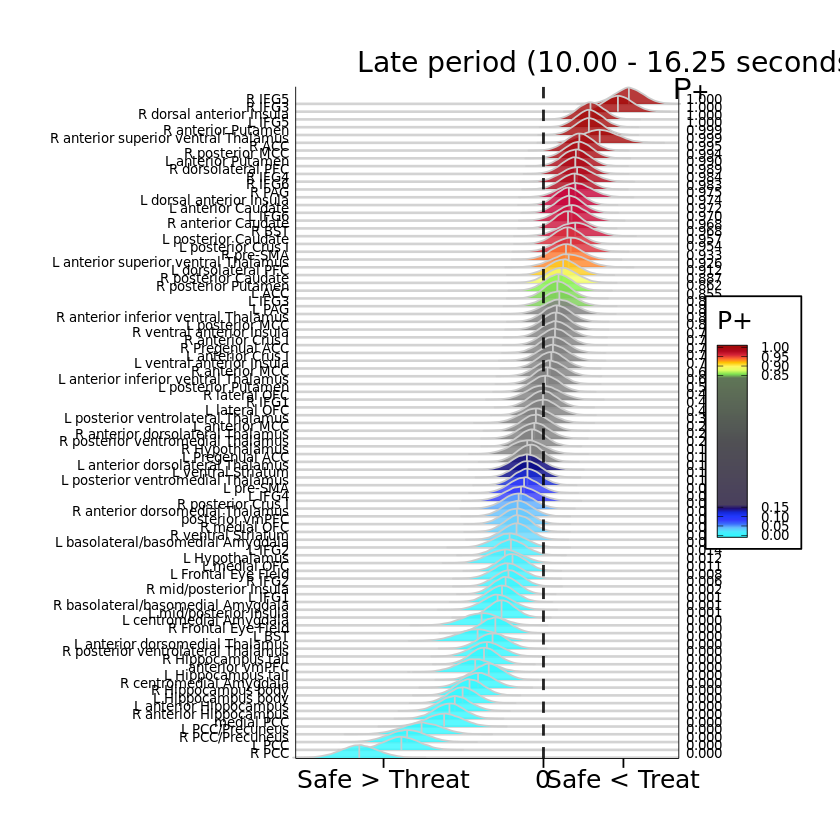

In [11]:
# Plot posterior distribution of intercept (threat vs. safe block) and save them
posteriors <- psROI(aa, bb, 'Intercept')

if (phase == "early"){
    title = "Early period (2.50 - 8.75 seconds)"
    
    plotPDP(posteriors) + labs(title = title) + 
        annotate('text', label = "P+", size = 6, x = 1.22, y = 87)
} else{
    title = "Late period (10.00 - 16.25 seconds)"
    
    plotPDP(posteriors) + labs(title = title) + 
        annotate('text', label = "P+", size = 6, x = 0.92, y = 87)
}

library("svglite")
ggsave(paste0(outDir,'Intercept.svg'), width= 12 , height = 20)

In [12]:
# generates ridge plots for covariates (TRAIT and STATE), and saves them.
for (ii in 1:length(EOIq)){
    posteriors <- psROI(aa, bb, EOIq[ii])
    if (EOIq[ii] != "Intercept"){
        plotPDP(posteriors) + labs(title = paste0("Posterior distribution of ", EOIq[ii], " at early phrase"))
        ggsave(paste0(outDir,EOIq[ii],'.png'), width= 12 , height = 20, units = "in", dpi = 300)
    }
}

Picking joint bandwidth of 0.00816

Picking joint bandwidth of 0.00743



# Diagnosis

In [15]:
# Posterior predictive check
pp_plot = pp_check(fm, nsamples = 1000) + 
                xlim(c(-4, 4)) + 
                theme(plot.title = element_text(size = 15, hjust = 0.5), 
                      legend.text = element_text(size = 15)) + 
                ggtitle("Posterior predictive check")

In [16]:
# Define sample skewness and kurtosis
skewness <- function(x){
    xdev <- x - mean(x)
    n <- length(x)
    numer <- sum(xdev^3)/n
    denom <- (sum(xdev^2)/n)^(3/2)
    return(numer/denom)
}

kurtosis <- function(x){
    xdev <- x - mean(x)
    n <- length(x)
    numer <- sum(xdev^4)/n
    denom <- (sum(xdev^2)/n)^2
    return(numer/denom - 3)
}

# Function to generate posterior predictive check for different statistics 
pp_check_stat <- function(fm, stat, xlim){
    plot <- pp_check(fm, 'stat', stat = stat, nsamples = 5000) +
                theme(plot.title = element_text(size = 15, hjust = 0.5), 
                      legend.text = element_text(size = 15)) +
                ggtitle(paste0('Posterior predictive check of ', stat)) +
                xlim(xlim)
    return(plot) 
}

In [17]:
pp_check.mean <- pp_check_stat(fm, 'mean', c(-0.13, 0.0))
pp_check.sd <- pp_check_stat(fm, 'sd', c(1.35, 1.6))
pp_check.skew <- pp_check_stat(fm, 'skewness', c(-2, 2))
pp_check.kurt <- pp_check_stat(fm, 'kurtosis', c(0, 20))


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



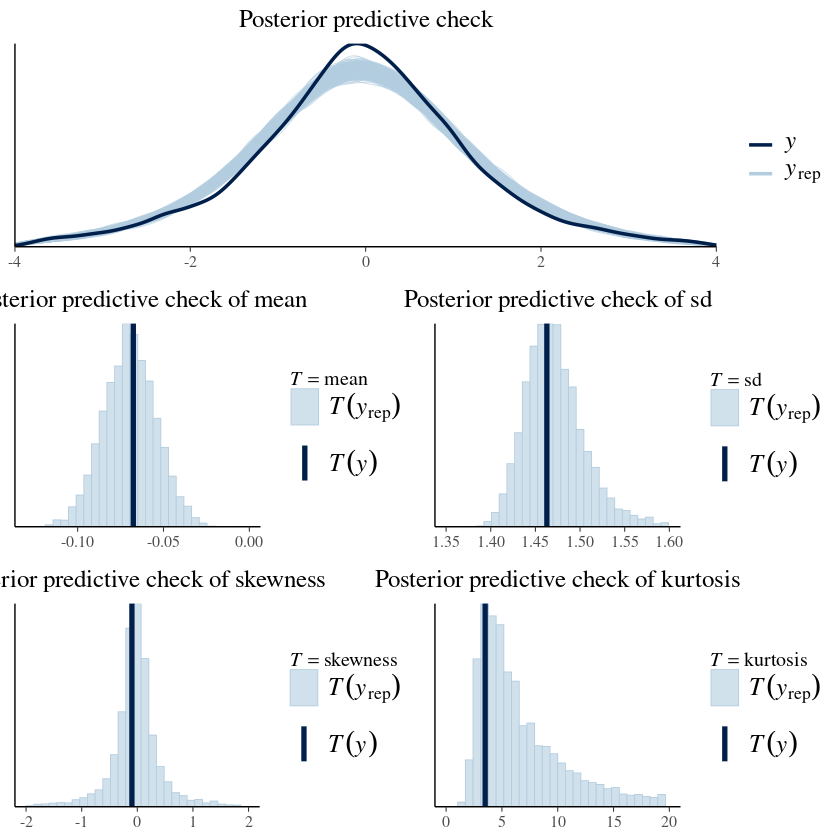

In [18]:
# Combine posterior predictive check of responses 
# with posterior predictive check of four types of statistics and save them
library(gridExtra)

lay <- rbind(c(1,1),
             c(2,3),
             c(4,5))
res <- grid.arrange(pp_plot, pp_check.mean, pp_check.sd, pp_check.skew, pp_check.kurt, 
                    layout_matrix = lay)
ggsave('results_offset/pp_check_early.png', width= 10 , height = 12, units = "in", dpi = 300, plot = res)